In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
# get_ipython().magic(u'matplotlib auto')
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# import torch
from tensorflow import keras
import statistics

In [2]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation
from tensorflow import reshape
from keras.utils import np_utils
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D,AveragePooling1D
from tensorflow.keras.layers import Input, LocallyConnected1D
from tensorflow.keras.layers import SeparableConv1D, Bidirectional
from tensorflow.keras.layers import LocallyConnected2D
from tensorflow.keras.layers import ZeroPadding2D,ZeroPadding1D, MaxPooling2D, Bidirectional
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import CSVLogger,LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std
# import coremltools
# from torch import nn, optim
# import torch.nn.functional as F
import scipy.io
from scipy import stats
#from IPython.display import display, HTML
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU,SimpleRNN
from tensorflow.keras.layers import TimeDistributed
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [4]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [5]:
# if tf.test.gpu_device_name(): 

#     print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

# else:

#    print("Please install GPU version of TF")

In [6]:
# import psutil
# import humanize
# # import os
# # import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [7]:
#if tf.test.gpu_device_name():
#    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
#else:
#    print("Please install GPU version of TF")

In [8]:
#print(tf.test.is_built_with_cuda())

In [9]:
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

In [10]:
import tensorflow as tf 

#if tf.test.gpu_device_name(): 
#
#   print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

#else:

#  print("Please install GPU version of TF")

In [11]:
#tf.test.gpu_device_name()

In [12]:
#gpu_available = tf.config.list_physical_devices('GPU')
#is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
#is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))
#print(is_cuda_gpu_min_3)

In [13]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(20, 14))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [14]:
# The number of steps within one time segment
TIME_PERIODS = 500
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 500
N_FEATURES = 10

In [15]:
column_names = ['C'+str(j) for j in range(1, N_FEATURES+1)]
lst = ['Class_label']
column_names = column_names+lst
print(column_names)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'Class_label']


In [16]:
def read_data_Train(file_path_Train):
    df_Train = pd.read_csv(file_path_Train,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Train['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Train['Class_label'] = df_Train['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Train.dropna(axis=0, how='any', inplace=True)
    return df_Train

In [17]:
def convert_to_float(x):
    try:
        return float(x)
    except:
        return np.nan

In [18]:
def show_basic_dataframe_info(dataframe):
    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [19]:
def read_data_Test(file_path_Test):
    df_Test = pd.read_csv(file_path_Test,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Test['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Test['Class_label'] = df_Test['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Test.dropna(axis=0, how='any', inplace=True)
    return df_Test

In [20]:
 pd.options.display.float_format = "{:,.5f}".format

In [21]:
# 15 function to segment data into trial lengths (trial length =513 samples in this dataset)
def create_segments_and_labels(df, time_steps,step,n_features, label_name):
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
      for j in range(1, n_features+1):
        L = ('C'+str(j)) 
        segments.append(df[str(L)].values[i: i + time_steps])
      label = stats.mode(df[label_name][i: i + time_steps])[0][0]
      labels.append(label)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [22]:
# import os
path='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/Total_process_TT/'

In [23]:
# file_path_train=path+'Train_data'+'.'+'csv'
file_path_train=path+'nina_pro_naveen_DB1_Train'+'.'+'csv'
print(file_path_train)

/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/Total_process_TT/nina_pro_naveen_DB1_Train.csv


In [24]:
file_path_test=path+'nina_pro_naveen_DB1_Test'+'.'+'csv'
# file_path_test=path+'Test_data'+'.'+'csv'
print(file_path_test)

/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/Total_process_TT/nina_pro_naveen_DB1_Test.csv


In [25]:
df_Train=read_data_Train(file_path_train)
show_basic_dataframe_info(df_Train)
df_Train.head(5)

Number of columns in the dataframe: 11
Number of rows in the dataframe: 4914000



,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label
0,0.00720,0.00242,0.00493,0.00242,0.00245,0.00241,0.00308,0.01634,0.00241,0.00247,1.00000
1,0.00836,0.00243,0.00478,0.00242,0.00245,0.00241,0.00312,0.01699,0.00241,0.00247,1.00000
2,0.00949,0.00243,0.00464,0.00242,0.00246,0.00241,0.00317,0.01762,0.00241,0.00248,1.00000
3,0.01052,0.00243,0.00451,0.00242,0.00246,0.00241,0.00322,0.01822,0.00242,0.00248,1.00000
4,0.01142,0.00243,0.00439,0.00242,0.00246,0.00241,0.00327,0.01877,0.00242,0.00248,1.00000


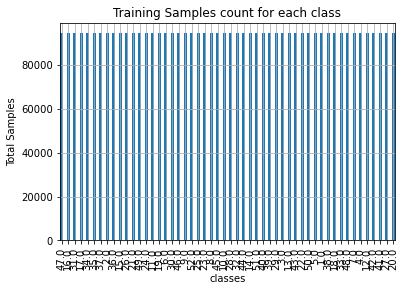

In [26]:
df_Train['Class_label'].value_counts().plot(kind='bar',
                                   title='Training Samples count for each class')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Total Samples')
plt.xlabel('classes')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

In [27]:
df_Test=read_data_Test(file_path_test)
show_basic_dataframe_info(df_Test)
df_Test.head(5)

Number of columns in the dataframe: 11
Number of rows in the dataframe: 2106000



,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label
0,0.03176,0.00247,0.00243,0.00240,0.00244,0.00240,0.00257,0.03562,0.00244,0.00241,1.00000
1,0.03205,0.00248,0.00244,0.00240,0.00245,0.00240,0.00258,0.03567,0.00244,0.00241,1.00000
2,0.03234,0.00248,0.00245,0.00240,0.00246,0.00240,0.00259,0.03569,0.00244,0.00241,1.00000
3,0.03261,0.00249,0.00246,0.00240,0.00246,0.00240,0.00260,0.03570,0.00244,0.00241,1.00000
4,0.03285,0.00249,0.00246,0.00240,0.00246,0.00240,0.00261,0.03566,0.00245,0.00241,1.00000


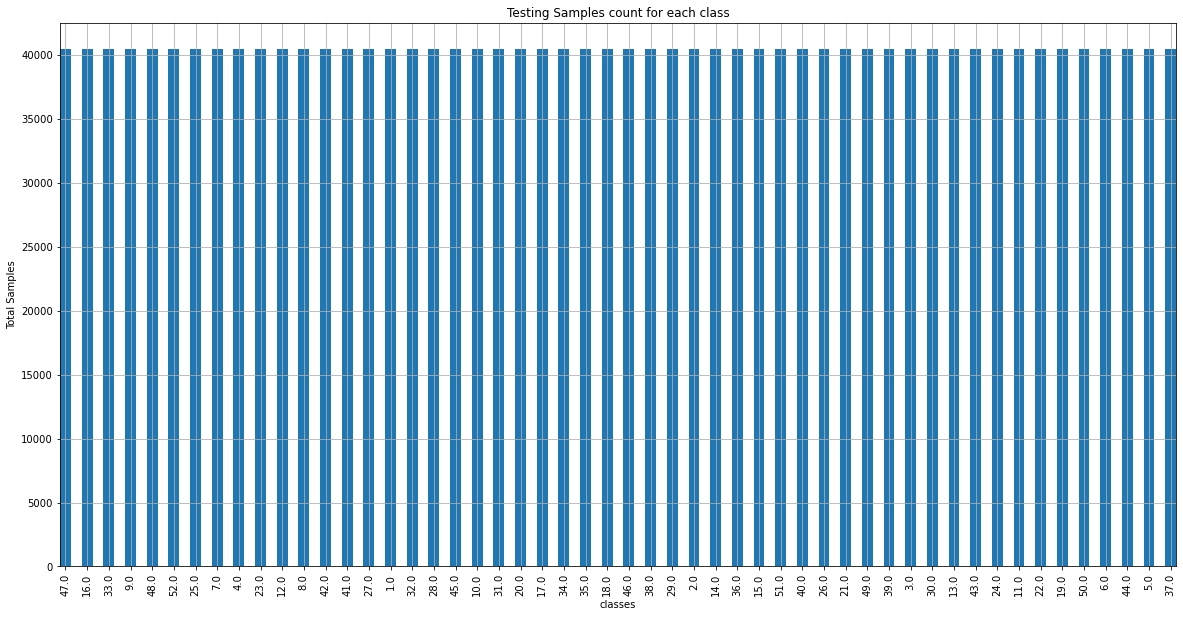

In [28]:
df_Test['Class_label'].value_counts().plot(kind='bar',
                                   title='Testing Samples count for each class')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Total Samples')
plt.xlabel('classes')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

In [29]:
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df_Train[LABEL] = le.fit_transform(df_Train['Class_label'].values.ravel())
# df_Valid[LABEL] = le.fit_transform(df_Valid['Class_label'].values.ravel())
df_Test[LABEL] = le.fit_transform(df_Test['Class_label'].values.ravel())

In [30]:
pd.options.display.float_format = "{:,.5f}".format
df_Train.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,0.00720,0.00242,0.00493,0.00242,0.00245,0.00241,0.00308,0.01634,0.00241,0.00247,1.00000,0
1,0.00836,0.00243,0.00478,0.00242,0.00245,0.00241,0.00312,0.01699,0.00241,0.00247,1.00000,0
2,0.00949,0.00243,0.00464,0.00242,0.00246,0.00241,0.00317,0.01762,0.00241,0.00248,1.00000,0
3,0.01052,0.00243,0.00451,0.00242,0.00246,0.00241,0.00322,0.01822,0.00242,0.00248,1.00000,0
4,0.01142,0.00243,0.00439,0.00242,0.00246,0.00241,0.00327,0.01877,0.00242,0.00248,1.00000,0


In [31]:
scaler = preprocessing.StandardScaler().fit(df_Train.iloc[:,0:N_FEATURES])

In [32]:
df_Train.iloc[:,0:N_FEATURES]=scaler.transform(df_Train.iloc[:,0:N_FEATURES])

In [33]:
pd.options.display.float_format = "{:,.5f}".format
df_Train.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,-0.67597,-0.64137,-0.51809,-0.43726,-0.37267,-0.45614,-0.76033,-0.90886,-0.51943,-0.77849,1.00000,0
1,-0.67360,-0.64137,-0.51846,-0.43725,-0.37263,-0.45613,-0.76027,-0.90759,-0.51942,-0.77848,1.00000,0
2,-0.67130,-0.64136,-0.51882,-0.43725,-0.37260,-0.45613,-0.76019,-0.90634,-0.51942,-0.77847,1.00000,0
3,-0.66919,-0.64136,-0.51915,-0.43724,-0.37256,-0.45613,-0.76012,-0.90516,-0.51942,-0.77846,1.00000,0
4,-0.66736,-0.64135,-0.51946,-0.43724,-0.37252,-0.45612,-0.76004,-0.90409,-0.51942,-0.77845,1.00000,0


In [34]:
pd.options.display.float_format = "{:,.5f}".format
df_Test.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,0.03176,0.00247,0.00243,0.00240,0.00244,0.00240,0.00257,0.03562,0.00244,0.00241,1.00000,0
1,0.03205,0.00248,0.00244,0.00240,0.00245,0.00240,0.00258,0.03567,0.00244,0.00241,1.00000,0
2,0.03234,0.00248,0.00245,0.00240,0.00246,0.00240,0.00259,0.03569,0.00244,0.00241,1.00000,0
3,0.03261,0.00249,0.00246,0.00240,0.00246,0.00240,0.00260,0.03570,0.00244,0.00241,1.00000,0
4,0.03285,0.00249,0.00246,0.00240,0.00246,0.00240,0.00261,0.03566,0.00245,0.00241,1.00000,0


In [35]:
df_Test.iloc[:,0:N_FEATURES]=scaler.transform(df_Test.iloc[:,0:N_FEATURES])

In [36]:
pd.options.display.float_format = "{:,.5f}".format
df_Test.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,Class_label,ActivityEncoded
0,-0.62585,-0.64122,-0.52438,-0.43732,-0.37277,-0.45618,-0.76115,-0.87110,-0.51936,-0.77862,1.00000,0
1,-0.62526,-0.64121,-0.52435,-0.43732,-0.37266,-0.45618,-0.76114,-0.87102,-0.51936,-0.77862,1.00000,0
2,-0.62467,-0.64120,-0.52433,-0.43731,-0.37256,-0.45618,-0.76112,-0.87096,-0.51935,-0.77862,1.00000,0
3,-0.62412,-0.64119,-0.52432,-0.43731,-0.37252,-0.45618,-0.76110,-0.87095,-0.51935,-0.77862,1.00000,0
4,-0.62363,-0.64117,-0.52432,-0.43731,-0.37250,-0.45618,-0.76109,-0.87102,-0.51934,-0.77862,1.00000,0


In [37]:
x_train, y_train = create_segments_and_labels(df_Train,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_train shape: ', x_train.shape)
# print(x_train)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
print('num_time_periods',num_time_periods)
print('num_sensors',num_sensors)
num_classes = le.classes_.size
print('class_list',list(le.classes_))
# input_shape = (num_time_periods,num_sensors)
# print(input_shape)
input_shape = (num_time_periods,num_sensors)
#x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train[0].shape)
print('input_shape:', input_shape)
x_train = x_train.astype('float32')
# x_train = [torch.tensor(arr, dtype=torch.float32) for arr in x_train]
# y_train = y_train.astype('float32')
# print(y_train)
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print(y_train_hot)
# y_train_hot= [torch.tensor(arr, dtype=torch.uint8) for arr in y_train_hot]
print('New y_train shape: ', y_train_hot.shape)

x_train shape:  (9827, 500, 10)
9827 training samples
y_train shape:  (9827,)
num_time_periods 500
num_sensors 10
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0]
x_train shape: (500, 10)
input_shape: (500, 10)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
New y_train shape:  (9827, 52)


In [38]:
x_test, y_test = create_segments_and_labels(df_Test,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_test shape: ', x_test.shape)
# print(x_train)
print(x_test.shape[0], 'testing samples')
print('y_test shape: ', y_test.shape)
# Set input_shape / reshape for Keras
#x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test_hot = np_utils.to_categorical(y_test, num_classes)

x_test shape:  (4211, 500, 10)
4211 testing samples
y_test shape:  (4211,)


In [39]:
n_steps, n_length, n_depth, n_chan = 100, 5, 10, 1

x_train = x_train.reshape(x_train.shape[0], n_steps, n_length, n_depth, n_chan)
print('x_train shape: ', x_train.shape)
# x_valid = x_valid.reshape(x_valid.shape[0], n_steps, n_length, n_depth)
# print('x_valid shape: ', x_valid.shape)
x_test = x_test.reshape(x_test.shape[0], n_steps, n_length,n_depth, n_chan)
print('x_test shape: ', x_test.shape)
n_outputs = y_train_hot.shape[1]
#print('n_outputs',n_outputs)

x_train shape:  (9827, 100, 5, 10, 1)
x_test shape:  (4211, 100, 5, 10, 1)


In [40]:
LABELS=[]
for i in range(1,n_outputs+1,1):
  LABELS.append (i)
print(LABELS)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


In [41]:
def step_decay(epoch):
  initial_lrate = 1e-4
  drop = 0.1
  epochs_drop = 70.0
  lrate = initial_lrate * tf.math.pow(drop,  
          tf.math.floor((1+epoch)/epochs_drop))
  return lrate

In [42]:
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [65]:
seq_len = x_train.shape[1]
n_channel = x_train.shape[-1]
# n_vector = 64
d_k = 64
d_v = 64
n_heads = 8
ff_dim = 4096
# ff_dim2 = 1024
N_depth = 2
N_depth1 = 4

In [66]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [67]:
# 22 Transformer encoder
class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.3, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    # print('input_shape',inputshape)
#     self.ffn = PositionWiseFFN(self.ff_dim, input_shape[0][-1])
    self.ff_dense1 = Dense(self.ff_dim,input_shape=input_shape,activation="tanh")
    self.ff_dense2 = Dense(input_shape[0][-1],input_shape=input_shape)
#     self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, padding="same", activation='relu')
#     self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], padding="same", kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_out = self.attn_normalize(inputs[0] + attn_layer)

#     ff_layer = self.ffn(attn_out)
    ff_layer = self.ff_dense1(attn_out)
    ff_layer = self.ff_dense2(ff_layer)
#     ff_layer = self.ff_dropout(ff_layer)
    ff_out = self.ff_normalize(attn_out + ff_layer)
#     print("ff_layer",ff_layer.shape)
    return ff_out 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
#                    'ff_dim2': self.ff_dim2,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config  

In [68]:
# 23 Single and multiattention functions
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)

    q = self.query(inputs[0])
    k = self.key(inputs[1])
#     print("q_shape",q.shape)
#     print("k_shape",k.shape)
    attn_weights = tf.matmul(q, k, transpose_b=True)
#     attn_weights = tf.math.add(q, k)
#     print("attn_shape", attn_weights.shape)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
#     print("attn_shape", attn_weights.shape)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
#     print("attn_shape", attn_weights.shape)
    
    v = self.value(inputs[2])
#     print("v_shape",v.shape)
    attn_out = tf.matmul(attn_weights, v)
#     attn_out = tf.math.add(attn_weights, v)
#     print("v1_shape",attn_out.shape)
    return attn_out     

In [69]:
class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
#     print("multi_out",len(attn))
    concat_attn = tf.concat(attn, axis=-1)
#     concat_attn = tf.transpose(concat_attn,perm=[0,2, 1])
#     print("concat_out",concat_attn.shape)
    multi_linear = self.linear(concat_attn)
#     print("multi_linear",multi_linear.shape)
    return multi_linear 

In [70]:
# 24 Time to vector conversion
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [71]:
# 25 model creation
def create_model():
  '''Initialize time and transformer layers'''
#   time_embedding = Time2Vector(seq_len)
  # print('time_embedding',time_embedding)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer4 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  #Conv1 = Conv1D(filters=64, kernel_size=9, padding='same', kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04)), \
       #                    input_shape=(none, n_steps,n_vector)) 
 
  '''Construct model'''
#   in_seq = Input(shape=(n_steps, n_length, n_depth))
  in_seq = Input(shape=(n_steps, n_length, n_depth, n_chan))
  x = in_seq
    
  x = Conv3D(64,kernel_size=(9,9,9),strides=2,padding='same',data_format='channels_last',kernel_regularizer=l1(1e-05),kernel_initializer='he_normal')(x)
#   x = LayerNormalization(epsilon=1e-6)(x)     
  x = BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)(x)
  x = Activation('tanh')(x)
  x = Dropout(0.3)(x)
  x = MaxPooling3D(pool_size=(2, 1, 2),strides=1)(x)  
  x = Conv3D(64,kernel_size=(5,5,5),strides=2,padding='same',data_format='channels_last',kernel_regularizer=l1(1e-05),kernel_initializer='he_normal')(x)
#   x = LayerNormalization(epsilon=1e-6)(x)
  x = BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)(x)
#   x = Activation('tanh')(x)
#   x = MaxPooling3D(pool_size=(3, 3, 1),strides=1)(x) 
# #   x = Bidirectional(LSTM(200,return_sequences=True))(x)
#   x = Dropout(0.3)(x)
#   x = Conv3D(64,3,strides=1,padding='same',data_format='channels_last',kernel_regularizer=l1(1e-05),kernel_initializer='he_normal')(x)
# #   x = LayerNormalization(epsilon=1e-6)(x)
#   x = BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)(x)
  x = Activation('tanh')(x)
  x = MaxPooling3D(pool_size=(2, 1, 2),strides=1)(x) 
#   x = Bidirectional(LSTM(200,return_sequences=True))(x)
  x = Dropout(0.3)(x)
#   x = Activation('relu')(x)
#   x = Conv3D(64,kernel_size=(3,3,3),strides=1,padding='same',kernel_regularizer=l1(1e-05),kernel_initializer='he_normal')(x)
# #   x = LayerNormalization(epsilon=1e-6)(x)
#   x = BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)(x)
#   x = Activation('tanh')(x)
# #   x = MaxPooling3D(pool_size=(2, 1, 2),strides=1)(x) 
# #   x = Bidirectional(LSTM(200,return_sequences=True))(x)
#   x = Dropout(0.3)(x)
#   x = Conv3D(64,3,strides=1,padding='same',kernel_regularizer=l1(1e-05),kernel_initializer='he_normal')(x)
# #   x = LayerNormalization(epsilon=1e-6)(x)
#   x = BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)(x)
#   x = Activation('tanh')(x)
# #   x = MaxPooling3D(pool_size=(2, 1, 2),strides=1)(x) 
# #   x = Bidirectional(LSTM(200,return_sequences=True))(x)
#   x = Dropout(0.3)(x)
  x = Activation('relu')(x)
  x = TimeDistributed(Flatten())(x)
  print("x_shape",x.shape)
  sp_att_out = x


#   sp_att_out = spatialattention()(x)
# #   tp_att_out = temporalattention()(x) 
# #   print("x_shape",x.shape)
# #   print("sp_att_shape",sp_att_out.shape)
# #   L_in = tf.matmul(x,sp_att_out,transpose_b=True)
#   L_in = LSTM(200,return_sequences=True)(sp_att_out)
#   L_in = Dropout(0.3)(L_in)
#   L_in = LSTM(200,return_sequences=True)(L_in)
#   L_in = LSTM(200,return_sequences=True)(L_in)
#   L_out = LSTM(200,return_sequences=True)(L_in)
# #   L_out = tf.matmul(L_in,tp_att_out,transpose_b=True)
#   tp_att_in = Dropout(0.3)(L_out)
#   tp_att_out = temporalattention()(tp_att_in)


  l = sp_att_out
  len = sp_att_out.shape[-2]  
  time_embedding = Time2Vector(len)
  x1 = time_embedding(sp_att_out)
  print("x1_shape",x1.shape)
  x = Concatenate(axis=-1)([l, x1])
  x2 = x
  for n in range(N_depth):  
        x = attn_layer1((x, x, x))
  print("x_shape",x.shape)
  L_out = x 
#   tp_att_out = temporalattention()(L_out)

#   x3 = tf.add(x, x2)
#   for n in range(N_depth1):  
#         x3 = attn_layer2((x3, x3, x3))
#   print("x3_shape",x3.shape)
    
#   for n in range(N_depth):  
#         x = attn_layer1((x, x, x))
#   print("x_shape",x.shape)
#   for n in range(N_depth1):  
#         x = attn_layer1((x, x, x))
#   print("x_shape",x.shape)
#   z = concatenate([x, x2])
  z = L_out
#   z = tf.add(x, x2) 
  print("z_shape",z.shape)
#   l = z
#   len = z.shape[-2]  
#   time_embedding = Time2Vector(len)
#   z1 = time_embedding(z)
#   print("z1_shape",z1.shape)
#   z = Concatenate(axis=-1)([l, z1])
#   for n in range(N_depth1):  
#         z = attn_layer2((z, z, z))
# #   print("z_shape",z.shape)
#   z = Conv1D(filters=64, kernel_size=5,padding="same",kernel_initializer='he_normal',strides=1,kernel_regularizer=l1(1e-04))(z)
# #   x = LayerNormalization(epsilon=1e-6)(x)
#   z = BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)(z)
#   z = Activation('tanh')(z)
# #   z = MaxPooling1D(pool_size=(3),strides=1))(z) 
# #   x = Bidirectional(LSTM(200,return_sequences=True))(x)
#   z = Dropout(0.3)(z)
  z = Flatten()(z)
#   x = Flatten()(x)
  #x = Dense(2048, activation='tanh')(x)
  #x = BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)(x)
#   x = Flatten()(x)
#   x = Dropout(0.5)(x)
  z = Dense(512, activation='tanh')(z)
#   z = Dense(128, activation='tanh')(z)  
#   z = Dense(64, activation='tanh')(z)
#   z = LayerNormalization(epsilon=1e-6)(z)
#   z = BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)(z)
#   x = Dropout(0.5)(x)  
#   x = Dense(512, activation='relu')(x)
  z = Dropout(0.3)(z)
  out = Dense(n_outputs, activation='softmax')(z)

  model = Model(inputs=in_seq, outputs=out)
  # adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
  # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [72]:
# 26 model summary
model = create_model()
model.summary()

x_shape (None, 24, 128)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
x1_shape (None, 24, 2)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
x_shape (None, 24, 130)
z_shape (None, 24, 130)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 5, 10,  0                                            
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 50, 3, 5, 64) 46720       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 50

In [73]:
adam=optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
checkpoint_filepath = '/media/naveen/nav/mat_codes/nina_DB1_codes/transformer/checkpoint.hdf5'
# model.load_weights(checkpoint_filepath) 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,verbose=1, monitor='val_accuracy',save_weights_only=True,save_best_only=True)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 5, 10,  0                                            
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 50, 3, 5, 64) 46720       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 50, 3, 5, 64) 256         conv3d_2[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 50, 3, 5, 64) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

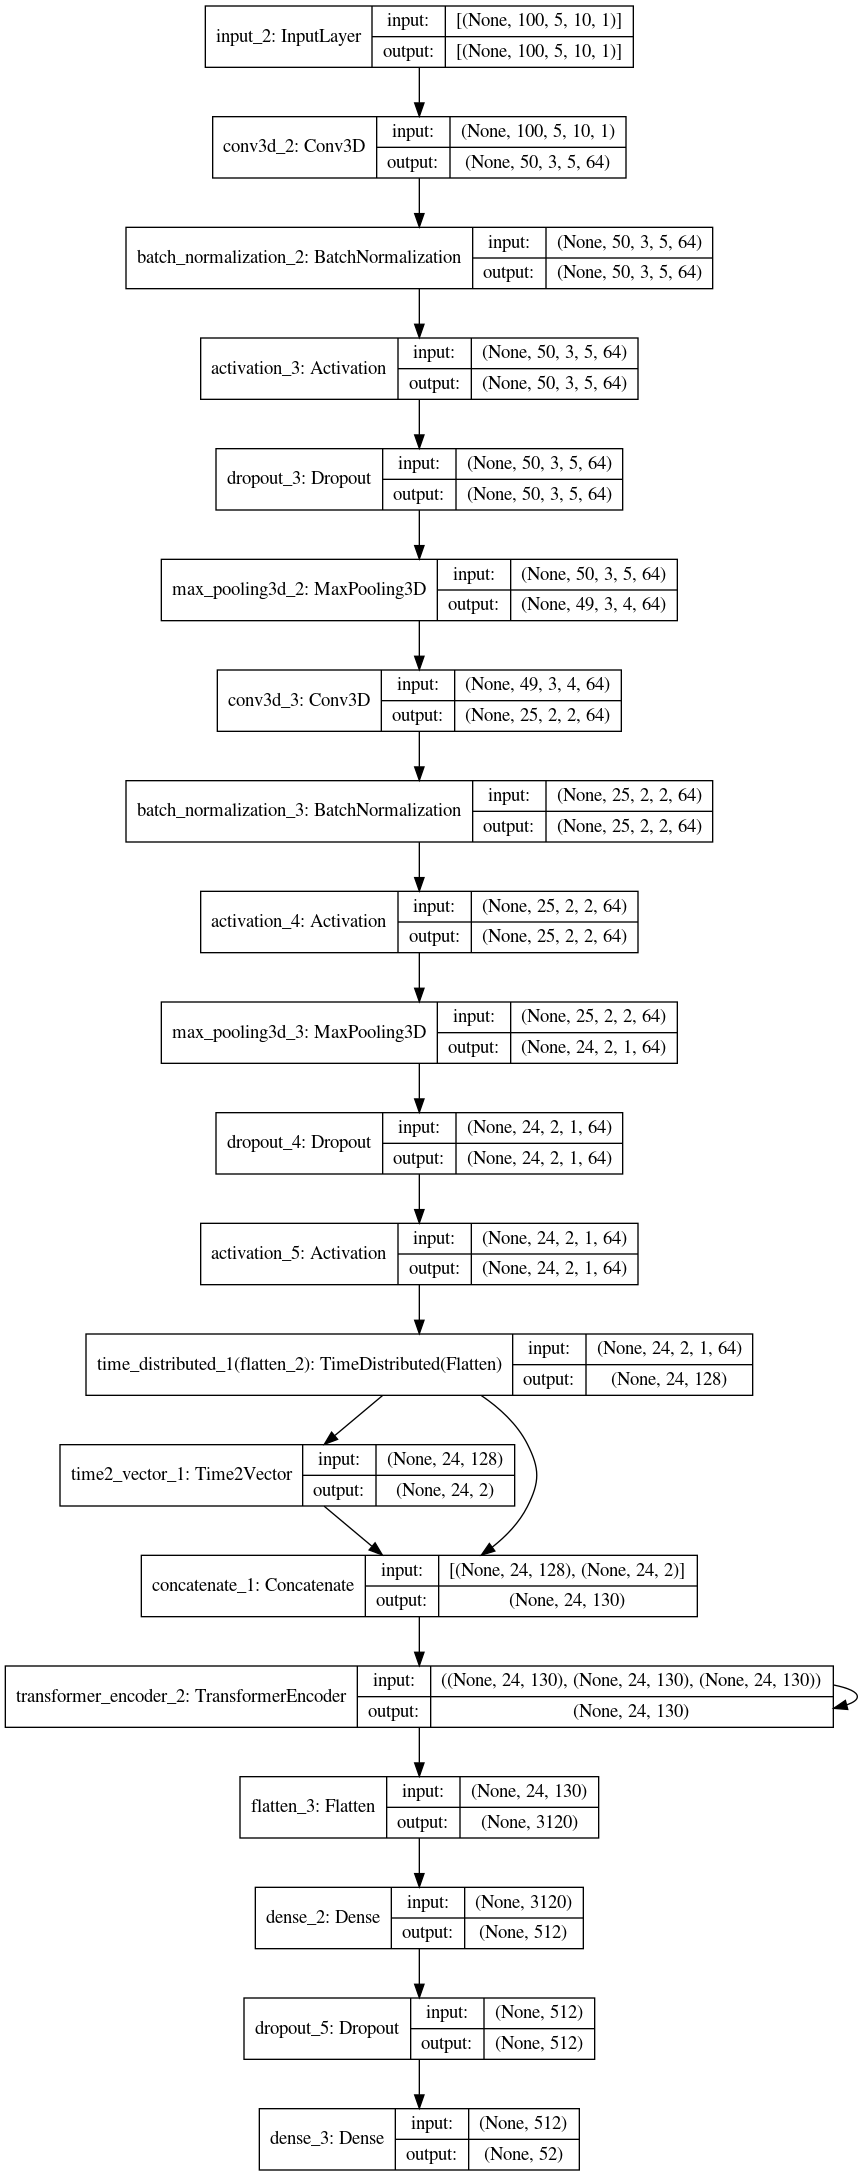

In [74]:
tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/transformer/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)

In [75]:
verbose, epochs, batch_size = 0, 200, 64

In [76]:
# adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# sgd=tfa.optimizers.SGDW(weight_decay=0.0001,learning_rate=0.1, momentum=0.9, nesterov=False, name='SGDW')
# sgd=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False, name='SGD')
#     tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/olsson/CNN20X10/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)

csv_logger = CSVLogger('/media/naveen/nav/mat_codes/nina_DB1_codes/transformer/CNN_nina_20X10.csv', append=True, separator=';')
history = model.fit(x_train, y_train_hot, epochs=epochs, batch_size=batch_size, callbacks=[csv_logger,checkpoint_callback,lrate,early],validation_data=(x_test, y_test_hot), verbose=1)

Epoch 1/200
154/154 [==============================] - 97s 581ms/step - loss: 4.2015 - accuracy: 0.0383 - val_loss: 3.8602 - val_accuracy: 0.0753

Epoch 00001: val_accuracy improved from -inf to 0.07528, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/transformer/checkpoint.hdf5
Epoch 2/200
154/154 [==============================] - 88s 573ms/step - loss: 3.5505 - accuracy: 0.1316 - val_loss: 3.3372 - val_accuracy: 0.1565

Epoch 00002: val_accuracy improved from 0.07528 to 0.15649, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/transformer/checkpoint.hdf5
Epoch 3/200
154/154 [==============================] - 87s 569ms/step - loss: 2.9220 - accuracy: 0.2493 - val_loss: 3.1452 - val_accuracy: 0.1947

Epoch 00003: val_accuracy improved from 0.15649 to 0.19473, saving model to /media/naveen/nav/mat_codes/nina_DB1_codes/transformer/checkpoint.hdf5
Epoch 4/200
154/154 [==============================] - 95s 617ms/step - loss: 2.6356 - accuracy: 0.2989 - val_loss: 3.018

KeyboardInterrupt: 

In [ ]:
best_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
print('epoch_number',best_index+1)
print('train accuracy and validation accuracy', history.history['accuracy'][best_index], history.history['val_accuracy'][best_index]) 

In [ ]:
print('train accuracy and validation accuracy', history.history['accuracy'][best_index], history.history['val_accuracy'][best_index])
model.load_weights(checkpoint_filepath) 
_, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
print('test_accuracy',testaccuracy)
# test_acc.append(testaccuracy)

In [ ]:
model.save('/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_naveen/CNN25X20/CNN_LSTM_nina_5X97')

In [ ]:
for i in history.history:
    print("history",i)
# facecolor='black'
DB1a=plt.figure(figsize=(10, 8),edgecolor='black')
# ax=figDB4.add_axes(("left", "bottom", "width", "height"))
ax= DB1a.add_axes((1,1,1,1))
ax.spines["top"].set_position(("outward", 0))
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("axes", 0))
ax.spines["right"].set_position(("outward", 0))

ax.spines["top"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")

# ax.spines["left"].set_bounds(-.5, .5)
# ax.spines["right"].set_linestyle("--")
# ax.spines["bottom"].set_linewidth(6)
# ax.spines["bottom"].set_capstyle("round")

# plt2.rcParams['figure.facecolor'] = 'white'
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')

# plt2.ylim(0)
# plt2.rcParams['figure.facecolor'] = 'white'

# ax = fig.add_axes((left, bottom, width, height))
ax.set(facecolor="white")
# ax.patch.set_alpha(1.0)
plt.ylim(0)
plt.legend()
plt.show()

In [ ]:
for i in history.history:
    print("history",i)
# facecolor='black'
# ax= figDB1.add_axes((1,1,1,1))
# ax.spines["top"].set_position(("outward", 0))
# ax.spines["bottom"].set_position(("data", 0))
# ax.spines["left"].set_position(("axes", 0))
# ax.spines["right"].set_position(("outward", 0))

# ax.spines["top"].set_color("black")
# ax.spines["left"].set_color("black")
# ax.spines["right"].set_color("black")
# ax.spines["bottom"].set_color("black") 

figDB1=plt.figure(figsize=(10, 8),edgecolor='black')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)

# SMALL_SIZE = 12
# MEDIUM_SIZE = 14
# BIGGER_SIZE = 18

# figBPR.suptitle('test title', fontsize=20)
#plt.rc('xlabel', fontsize=14, weight = 'bold')
#plt.rc('ylabel', fontsize=14, weight = 'bold')

# plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
# plt.rc('axes', labelsize=MEDIUM_SIZE )     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE, weight = 'bold')    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE )  # fontsize of the figure title

# ax=figDB1.add_axes(("left", "bottom", "width", "height"))
# ax= figDB1.add_axes((1,1,1,1))
# ax.spines["top"].set_position(("outward", 0))
# ax.spines["bottom"].set_position(("data", 0))
# ax.spines["left"].set_position(("axes", 0))
# ax.spines["right"].set_position(("outward", 0))

# ax.spines["top"].set_color("black")
# ax.spines["left"].set_color("black")
# ax.spines["right"].set_color("black")
# ax.spines["bottom"].set_color("black")

# ax.spines["left"].set_bounds(-.5, .5)
# ax.spines["right"].set_linestyle("--")
ax.spines["top"].set_linewidth(3)
ax.spines["top"].set_linestyle("-")
ax.spines["bottom"].set_linewidth(3)
ax.spines["bottom"].set_linestyle("-")
ax.spines["left"].set_linewidth(3)
ax.spines["left"].set_linestyle("-")
ax.spines["right"].set_linewidth(3)
ax.spines["right"].set_linestyle("-")
# ax.spines["bottom"].set_capstyle("round")

# plt2.rcParams['figure.facecolor'] = 'white'
plt.plot(history.history['loss'], 'r-', linewidth=3, label='Loss on training data')
plt.plot(history.history['val_loss'], 'b-', linewidth=3, label='Loss on validation data')
# plt.title('Loss curve for NinaPro DB1',fontsize=18, weight = 'bold')

plt.ylabel('Loss',fontsize=30, weight = 'bold')
plt.xlabel('no. of training epochs',fontsize=30, weight = 'bold')
# plt2.ylim(0)
# plt2.rcParams['figure.facecolor'] = 'white'

# ax = fig.add_axes((left, bottom, width, height))
ax.set(facecolor="white")
# ax.patch.set_alpha(1.0)
plt.ylim(0)
plt.legend()
plt.show()

In [ ]:
figDB1.savefig('/media/naveen/nav/plots/NinaPro_DB1_25X20.eps',transparent=False)
# figDB1.savefig('/media/naveen/nav/plots/NinaPro_DB1_25X20.pdf',transparent=False)

In [ ]:
model.load_weights(checkpoint_filepath) 
_, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
print('test_accuracy',testaccuracy)

In [ ]:
y_pred_train = model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#max_y_train = np.argmax(y_train, axis=1)
show_confusion_matrix(y_train, max_y_pred_train)
print(classification_report(y_train, max_y_pred_train))

In [ ]:
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

In [ ]:
# # 25 model creation
# def create_model():
#   '''Initialize time and transformer layers'''
#   time_embedding = Time2Vector(seq_len)
#   # print('time_embedding',time_embedding)
#   attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer4 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer5 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

#   '''Construct model'''
#   in_seq = Input(shape=(seq_len, n_vector))
#   x = in_seq
#   print("x_shape",x.shape)
#   x = time_embedding(in_seq)
#   print("x1_shape",x.shape)
#   x = Concatenate(axis=-1)([in_seq, x])
#   x = attn_layer1((x, x, x))
#   x = attn_layer2((x, x, x))
# #   x = attn_layer3((x, x, x))
# #   x = attn_layer4((x, x, x))
# #   x = attn_layer5((x, x, x))
# #   x = GlobalAveragePooling1D(data_format='channels_first')(x)
# #   x = TimeDistributed(Flatten())(x)
# # #   x = Flatten()(x)
# #   x = Bidirectional(LSTM(200,return_sequences=True))(x)
# #   x = Dropout(0.3)(x)
# #   x = Bidirectional(LSTM(200,return_sequences=True))(x)
# #   x = Dropout(0.3)(x)
# #   x = Flatten()(x)
# #   time_embedding1 = Time2Vector(n_vector)
# #   y = tf.transpose(x,perm=[0,2, 1])
# # #   print("y_shape",y.shape)  
# # #   in_seq2 = Input(shape=(n_vector, seq_len))
# # #   y = in_seq2
# # #   y = time_embedding1(in_seq2)
# # #   y = Concatenate(axis=-1)([in_seq2, y])
# # #   print("y_shape",y.shape)  
# #   y = attn_layer3((y, y, y))
# #   y = attn_layer4((y, y, y))
    
#   x = Flatten()(x)
#   x = Dense(2048, activation='tanh')(x)
#   x = BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)(x)
# #   x1 = Flatten()(x1)
# #   x1 = Dropout(0.1)(x1)
# #   x1 = Dense(1024, activation='tanh')(x1)
# #   x1 = BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)(x1)  
# #   x1 = Flatten()(x1)  

# #   y = Flatten()(y)
# #   y = Dense(2048, activation='tanh')(y)
# #   y = BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)(y)
# # #   y = Flatten()(y)
# # #   y = Dropout(0.1)(y)
# # #   y = Dense(1024, activation='tanh')(y)
# # #   y = BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)(y)  
# #   y = Flatten()(y) 
# # #   y = Dropout(0.1)(y)
# #   z = concatenate([x1, y])
#   x = Dense(1024, activation='tanh')(x)
#   x = BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)(x)
#   x = Dense(512, activation='relu')(x)
#   x = Dropout(0.1)(x)
#   out = Dense(n_outputs, activation='softmax')(x)

#   model = Model(inputs=in_seq, outputs=out)
#   # adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#   # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#   return model